In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import talib as ta
import datetime

In [34]:
from scipy.optimize import brute
class SMAVectorBacktester(object):
    def __init__(self, symbol, EMA1, EMA2, start, end):
        self.symbol = symbol
        self.EMA1 = EMA1
        self.EMA2 = EMA2
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
    
    def get_data(self):
        df = yf.download(f'{self.symbol}.NS', self.start, self.end, interval = '1h')
        df['returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
        df['EMA1'] = ta.EMA(df['Adj Close'], self.EMA1)
        df['EMA2'] = ta.EMA(df['Adj Close'], self.EMA2) 
        self.data = df
    
    def set_parameters(self, EMA1=None, EMA2=None):
        if EMA1 is not None:
            self.EMA1 = EMA1
            self.data['EMA1'] = ta.EMA(self.data['Adj Close'], timeperiod = self.EMA1)
        if EMA2 is not None:
            self.EMA2 = EMA2
            self.data['EMA2'] = ta.EMA(self.data['Adj Close'], timeperiod = self.EMA2)
    
    def run_strategy(self):
        data = self.data.copy().dropna()
        data['position'] = np.where(data['EMA1'] > data['EMA2'],1,-1)
        data['strategy'] = data['position'].shift(1)*data['returns']
        data.dropna(inplace = True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        #gross performance of the strategy
        aperf = data['cstrategy'].iloc[-1]
        #out performance of the strategy
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)
    
    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        title = '%s | EMA1 = %d, EMA2 = %d' % (self.symbol, self.EMA1, self.EMA2)
        self.results[['creturns', 'cstrategy']].plot(title = title, figsize = (14,6))
        
    def update_and_run(self, EMA):
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.run_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish = None)
        return opt, -self.update_and_run(opt)
              

[*********************100%***********************]  1 of 1 completed


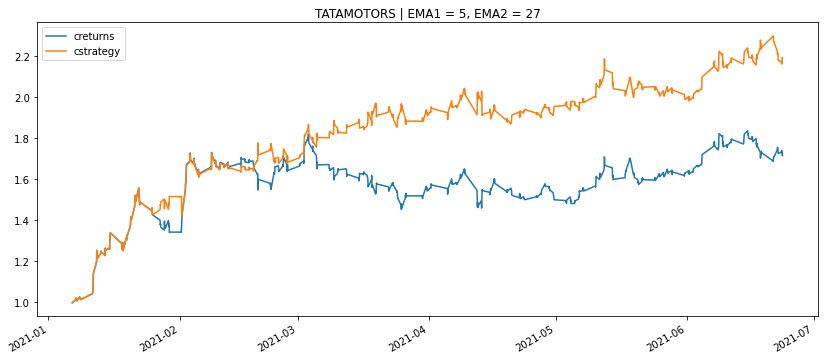

In [37]:
smabt = SMAVectorBacktester('TATAMOTORS', 50, 200, '2021-01-01', '2021-06-24')
# smabt.run_strategy()
# %%time
smabt.optimize_parameters((5,50,2),(5,50,2))
smabt.plot_results()

In [8]:
df = yf.download('TATAMOTORS.NS', '2021-01-01', '2021-06-24', interval = '1h')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2021-01-01 09:15:00+05:30,184.600006,186.100006,184.600006,185.000000,185.000000,0
2021-01-01 10:15:00+05:30,185.300003,185.449997,184.500000,185.199997,185.199997,2433475
2021-01-01 11:15:00+05:30,185.300003,185.449997,184.850006,185.199997,185.199997,3967614
2021-01-01 12:15:00+05:30,185.000000,185.649994,184.850006,185.300003,185.300003,3765254
2021-01-01 13:15:00+05:30,185.399994,185.949997,184.850006,185.699997,185.699997,4052944
...,...,...,...,...,...,...
2021-06-23 11:15:00+05:30,339.549988,340.450012,338.500000,340.149994,340.149994,4599970
2021-06-23 12:15:00+05:30,338.950012,340.450012,337.350006,337.950012,337.950012,3565242
2021-06-23 13:15:00+05:30,339.299988,339.899994,337.299988,338.750000,338.750000,5084818
2021-06-23 14:15:00+05:30,339.500000,339.899994,335.100006,335.149994,335.149994,9483535
